In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0'

# Loading Data

In [3]:
dataset = load_dataset("trec")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [4]:
train_df = pd.DataFrame({'text' : train_dataset['text'], 'fine_label' : train_dataset['fine_label']})
test_df = pd.DataFrame({'text' : test_dataset['text'], 'fine_label' : test_dataset['fine_label']})

In [5]:
train_df.head()

,text,fine_label
0,How did serfdom develop in and then leave Russ...,26
1,What films featured the character Popeye Doyle ?,5
2,How can I find a list of celebrities ' real na...,26
3,What fowl grabs the spotlight after the Chines...,2
4,What is the full form of .com ?,1


In [10]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(train_df, test_size=0.95, stratify=train_df['fine_label'])

In [11]:
initial_labeled_set

,text,fine_label
3419,What substance did Joseph Priestley name for i...,18
1881,How many presidents have died on the 4th of Ju...,38
4995,How do I contact Answers.com direct ?,26
3378,How do you build a solar car for a high school...,26
1989,Which two products use a tiger as their symbol ?,15
...,...,...
1760,What city in the U.S. experienced the most gro...,32
5263,What President had never held an elected offic...,29
4936,What 's the name of Pittsburgh 's baseball team ?,28
2245,What are the environmental influences on plant...,25


# Spliting Data into train_encodings, test_encodings

In [12]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [14]:
train_encodings = tokenizer(initial_labeled_set['text'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].to_list(), truncation=True, padding=True)
train_labels = initial_labeled_set.fine_label.to_list()
test_labels = test_df.fine_label.to_list()

In [17]:
num_labels = 50
label_to_id = {
    'Abbreviation': 0,
    'Expression abbreviated': 1,
    'Animal': 2,
    'Organ of body': 3,
    'Color': 4,
    'Invention, book and other creative piece': 5,
    'Currency name': 6,
    'Disease and medicine': 7,
    'Event': 8,
    'Food': 9,
    'Musical instrument': 10,
    'Language': 11,
    'Letter like a-z': 12,
    'Other entity': 13,
    'Plant': 14,
    'Product': 15,
    'Religion': 16,
    'Sport': 17,
    'Element and substance': 18,
    'Symbols and sign': 19,
    'Techniques and method': 20,
    'Equivalent term': 21,
    'Vehicle': 22,
    'Word with a special property': 23,
    'Definition of something': 24,
    'Description of something': 25,
    'Manner of an action': 26,
    'Reason': 27,
    'Group or organization of persons': 28,
    'Individual': 29,
    'Title of a person': 30,
    'Description of a person': 31,
    'City': 32,
    'Country': 33,
    'Mountain': 34,
    'Other location': 35,
    'State': 36,
    'Postcode or other code': 37,
    'Number of something': 38,
    'Date': 39,
    'Distance, linear measure': 40,
    'Price': 41,
    'Order, rank': 42,
    'Other number': 43,
    'Lasting time of something': 44,
    'Percent, fraction': 45,
    'Speed': 46,
    'Temperature': 47,
    'Size, area and volume': 48,
    'Weight': 49
}



id_to_label = {value : key for key, value in label_to_id.items()} 

In [19]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=50, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [20]:
training_args = TrainingArguments(
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    num_train_epochs=7,  # Reduced number of epochs.
    per_device_train_batch_size=10,  # Reduced batch size for training.
    per_device_eval_batch_size=35,  # Reduced batch size for evaluation.
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    #fp16=True,  # Enable mixed precision training.
)

In [21]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [22]:
def compute_metrics(pred):
    
    ''' 
    Compute Metrics

    This function computes various classification metrics based on the model's predictions and true labels, 
    including accuracy, F1 score, precision, and recall.

    Args:
        pred: A prediction object containing the true labels and predicted probabilities.

    Returns:
        metrics (dict): A dictionary containing the computed metrics:
            - 'Accuracy': The accuracy of the model's predictions.
            - 'F1': The macro F1 score.
            - 'Precision': The macro precision score.
            - 'Recall': The macro recall score.'''


    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [23]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [24]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [25]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [27]:
probabilities = tf.nn.softmax(predictions.predictions[0] )


In [28]:
probabilities

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.0258021 , 0.02351519, 0.01634781, 0.01217542, 0.01281465,
       0.02467192, 0.01745019, 0.02862006, 0.02317018, 0.02026442,
       0.01641606, 0.01196124, 0.01917081, 0.02404782, 0.0164109 ,
       0.03274611, 0.01481279, 0.02823277, 0.01496903, 0.01616346,
       0.02938391, 0.02112618, 0.01320469, 0.01681057, 0.0199845 ,
       0.02903154, 0.03009969, 0.01858445, 0.01943723, 0.02181489,
       0.02354941, 0.02026298, 0.02413838, 0.01618954, 0.02288279,
       0.02695143, 0.01176999, 0.01272145, 0.01823958, 0.01937616,
       0.03034929, 0.02105668, 0.01222542, 0.01295799, 0.01940037,
       0.02326288, 0.01679388, 0.02428768, 0.0105029 , 0.01384072],
      dtype=float32)>

## An Active Learning Approach Based On Uncertain Sampling

In [29]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,text,fine_label
3419,What substance did Joseph Priestley name for i...,18
1881,How many presidents have died on the 4th of Ju...,38
4995,How do I contact Answers.com direct ?,26
3378,How do you build a solar car for a high school...,26
1989,Which two products use a tiger as their symbol ?,15


In [30]:
initial_labeled_set.shape

(272, 2)

# 

In [31]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [39]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'text' for text data and 'coarse_label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'text': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'coarse_label': The original coarse labels from the input data. ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['text'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.fine_label.to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'text' : data['text'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['fine_label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


In [40]:
test_df['fine_label'].skew()

-0.5929439081622787

# Simulated Active Learning

In [41]:
initial_labeled_set = test_df

In [42]:
initial_labeled_set

,text,fine_label
0,How far is it from Denver to Aspen ?,40
1,"What county is Modesto , California in ?",32
2,Who was Galileo ?,31
3,What is an atom ?,24
4,When did Hawaii become a state ?,39
...,...,...
495,Who was the 22nd President of the US ?,29
496,What is the money they use in Zambia ?,6
497,How many feet in a mile ?,38
498,What is the birthstone of October ?,18


In [43]:
hundreds_rows_pred = predict_and_calculate_entropy(initial_labeled_set)

  0%|          | 0/15 [00:00<?, ?it/s]

In [44]:
hundreds_rows_pred

,fine_label,text,predicted_Label,predicted_Probability,Entropy
158,35,In the late 1700 's British convicts were used...,40,0.596739,3.878440
318,13,What are the two types of twins ?,15,0.612430,3.877137
299,4,What color is a giraffe 's tongue ?,15,0.581302,3.875459
154,28,What baseball team was the first to make numbe...,20,0.500323,3.875252
454,47,How cold should a refrigerator be ?,15,0.658486,3.875235
...,...,...,...,...,...
174,35,Where is the Shawnee National Forest ?,35,0.696515,3.835715
151,29,Who discovered radium ?,35,0.703612,3.835310
34,39,When did John F. Kennedy get elected as Presid...,35,0.713202,3.831922
82,29,Who was elected president of South Africa in 1...,35,0.690025,3.831551


# Active Learning

In [46]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(15):
    n += 10
    #print(n)
    #print(hundreds_rows_pred[0:n])
    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['text'].to_list(), truncation=True, padding=True)
    initial_labeled_labels = hundreds_rows_pred[0:n].fine_label.to_list()
    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

   
    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()  


    #hundreds_rows_pred = predict_and_calculate_entropy(hundreds_rows_pred)


    metrics = trainer.evaluate()

    print('eval_Accuracy :',metrics['eval_Accuracy'])

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



  0%|          | 0/7 [00:00<?, ?it/s]

{'train_runtime': 0.9682, 'train_samples_per_second': 72.299, 'train_steps_per_second': 7.23, 'train_loss': 3.994554247174944, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.046


  0%|          | 0/14 [00:00<?, ?it/s]

{'train_runtime': 1.4797, 'train_samples_per_second': 94.616, 'train_steps_per_second': 9.462, 'train_loss': 3.9430176871163503, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.058


  0%|          | 0/21 [00:00<?, ?it/s]

{'train_runtime': 2.1408, 'train_samples_per_second': 98.096, 'train_steps_per_second': 9.81, 'train_loss': 3.7672217232840404, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.036


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_runtime': 2.8323, 'train_samples_per_second': 98.858, 'train_steps_per_second': 9.886, 'train_loss': 3.522611618041992, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.106


  0%|          | 0/35 [00:00<?, ?it/s]

{'train_runtime': 3.6266, 'train_samples_per_second': 96.509, 'train_steps_per_second': 9.651, 'train_loss': 3.2330906459263393, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.188


  0%|          | 0/42 [00:00<?, ?it/s]

{'train_runtime': 4.4144, 'train_samples_per_second': 95.143, 'train_steps_per_second': 9.514, 'train_loss': 2.914369855608259, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.264


  0%|          | 0/49 [00:00<?, ?it/s]

{'train_runtime': 5.2452, 'train_samples_per_second': 93.418, 'train_steps_per_second': 9.342, 'train_loss': 2.6162551568478953, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.26


  0%|          | 0/56 [00:00<?, ?it/s]

{'loss': 2.2347, 'learning_rate': 2.5e-05, 'epoch': 6.25}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 3.0882503986358643, 'eval_Accuracy': 0.332, 'eval_F1': 0.10854501331352234, 'eval_Precision': 0.902317739512396, 'eval_Recall': 0.15729858104858105, 'eval_runtime': 0.7604, 'eval_samples_per_second': 657.561, 'eval_steps_per_second': 19.727, 'epoch': 6.25}
{'train_runtime': 6.757, 'train_samples_per_second': 82.877, 'train_steps_per_second': 8.288, 'train_loss': 2.1919349942888533, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.358


  0%|          | 0/63 [00:00<?, ?it/s]

{'loss': 1.8152, 'learning_rate': 2.5e-05, 'epoch': 5.56}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.751643657684326, 'eval_Accuracy': 0.394, 'eval_F1': 0.18819315570268638, 'eval_Precision': 0.9011186607550091, 'eval_Recall': 0.21851379440665153, 'eval_runtime': 0.7618, 'eval_samples_per_second': 656.315, 'eval_steps_per_second': 19.689, 'epoch': 5.56}
{'train_runtime': 7.4867, 'train_samples_per_second': 84.149, 'train_steps_per_second': 8.415, 'train_loss': 1.7656853993733723, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.412


  0%|          | 0/70 [00:00<?, ?it/s]

{'loss': 1.4347, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.487318754196167, 'eval_Accuracy': 0.418, 'eval_F1': 0.2078652625282636, 'eval_Precision': 0.8688144644739866, 'eval_Recall': 0.25284274007706065, 'eval_runtime': 0.7629, 'eval_samples_per_second': 655.41, 'eval_steps_per_second': 19.662, 'epoch': 5.0}
{'train_runtime': 8.1676, 'train_samples_per_second': 85.705, 'train_steps_per_second': 8.57, 'train_loss': 1.361130932399205, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.468


  0%|          | 0/77 [00:00<?, ?it/s]

{'loss': 1.087, 'learning_rate': 2.5e-05, 'epoch': 4.55}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.871028184890747, 'eval_Accuracy': 0.64, 'eval_F1': 0.4008987239951044, 'eval_Precision': 0.8734480317956577, 'eval_Recall': 0.3955692104385484, 'eval_runtime': 0.7711, 'eval_samples_per_second': 648.412, 'eval_steps_per_second': 19.452, 'epoch': 4.55}
{'train_runtime': 8.8867, 'train_samples_per_second': 86.646, 'train_steps_per_second': 8.665, 'train_loss': 1.0025349901868152, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.676


  0%|          | 0/84 [00:00<?, ?it/s]

{'loss': 0.7785, 'learning_rate': 2.5e-05, 'epoch': 4.17}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.4046698808670044, 'eval_Accuracy': 0.756, 'eval_F1': 0.45361142965410006, 'eval_Precision': 0.8500125528680371, 'eval_Recall': 0.4639480209427945, 'eval_runtime': 0.7586, 'eval_samples_per_second': 659.133, 'eval_steps_per_second': 19.774, 'epoch': 4.17}
{'train_runtime': 9.5833, 'train_samples_per_second': 87.653, 'train_steps_per_second': 8.765, 'train_loss': 0.6925119218372163, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.772


  0%|          | 0/91 [00:00<?, ?it/s]

{'loss': 0.4577, 'learning_rate': 2.5e-05, 'epoch': 3.85}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.082638144493103, 'eval_Accuracy': 0.778, 'eval_F1': 0.5319351484952423, 'eval_Precision': 0.8901388726367216, 'eval_Recall': 0.5241855421646362, 'eval_runtime': 0.7714, 'eval_samples_per_second': 648.203, 'eval_steps_per_second': 19.446, 'epoch': 3.85}
{'train_runtime': 10.4064, 'train_samples_per_second': 87.446, 'train_steps_per_second': 8.745, 'train_loss': 0.3855577615591196, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.792


  0%|          | 0/98 [00:00<?, ?it/s]

{'loss': 0.2196, 'learning_rate': 2.5e-05, 'epoch': 3.57}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.9647507071495056, 'eval_Accuracy': 0.804, 'eval_F1': 0.5508510212365076, 'eval_Precision': 0.8882217660981456, 'eval_Recall': 0.5508749976955553, 'eval_runtime': 0.7629, 'eval_samples_per_second': 655.374, 'eval_steps_per_second': 19.661, 'epoch': 3.57}
{'train_runtime': 11.0701, 'train_samples_per_second': 88.526, 'train_steps_per_second': 8.853, 'train_loss': 0.1836093250586062, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.806


  0%|          | 0/105 [00:00<?, ?it/s]

{'loss': 0.1473, 'learning_rate': 2.5e-05, 'epoch': 3.33}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.8873711228370667, 'eval_Accuracy': 0.812, 'eval_F1': 0.5607750700640242, 'eval_Precision': 0.8543043840912988, 'eval_Recall': 0.5787208026842173, 'eval_runtime': 0.7631, 'eval_samples_per_second': 655.252, 'eval_steps_per_second': 19.658, 'epoch': 3.33}
{'loss': 0.0999, 'learning_rate': 5e-05, 'epoch': 6.67}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.8928499221801758, 'eval_Accuracy': 0.808, 'eval_F1': 0.5543734472911558, 'eval_Precision': 0.8410322448327063, 'eval_Recall': 0.5753574654794167, 'eval_runtime': 0.7576, 'eval_samples_per_second': 659.975, 'eval_steps_per_second': 19.799, 'epoch': 6.67}
{'train_runtime': 12.6246, 'train_samples_per_second': 83.171, 'train_steps_per_second': 8.317, 'train_loss': 0.12388668003536406, 'epoch': 7.0}


  0%|          | 0/15 [00:00<?, ?it/s]

eval_Accuracy : 0.808


In [47]:
bert_pred_df = pd.DataFrame({'Bert_Pred' : predicted_labels, 'Label' : test_df['fine_label'].to_list() }) 

bert_pred_df.to_csv('Trec_fine_label_Bert_Pred.csv',index=False)

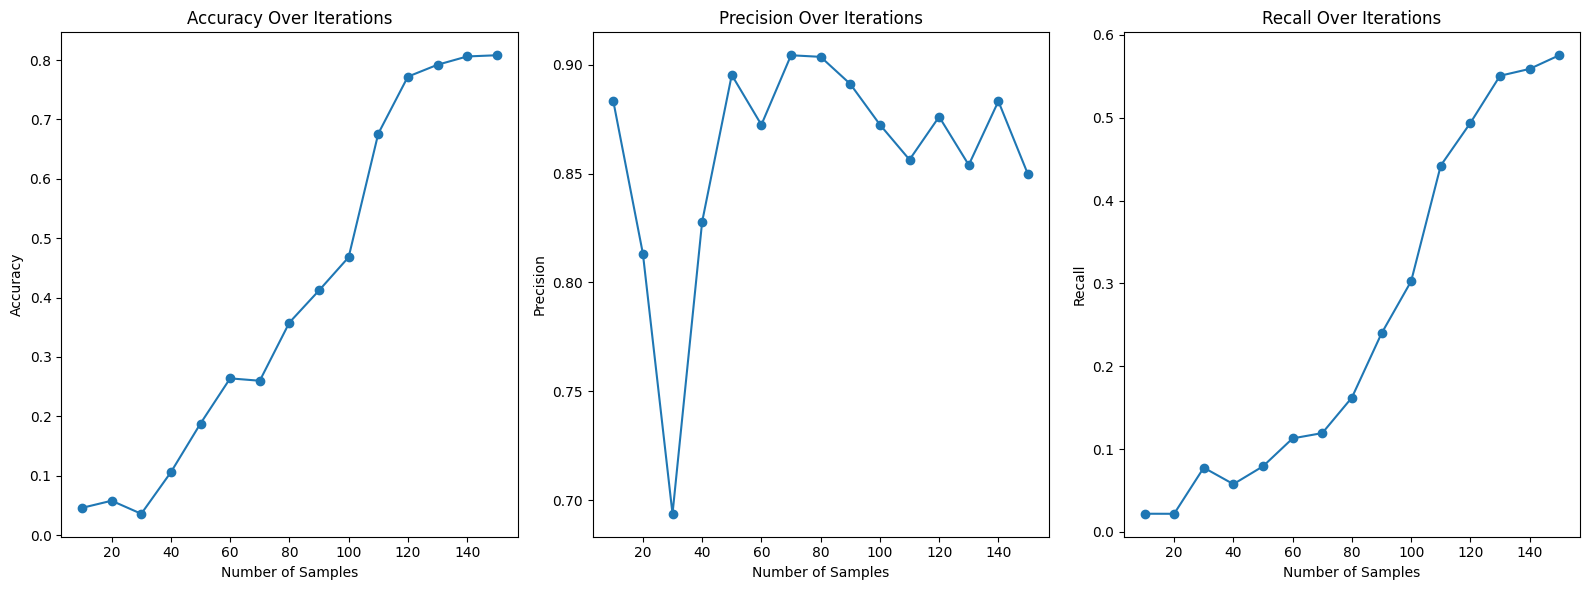

In [48]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [49]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['fine_label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/15 [00:00<?, ?it/s]

accuracy 81.0% 


In [50]:
from sklearn.metrics import confusion_matrix


# Confusion Matrix

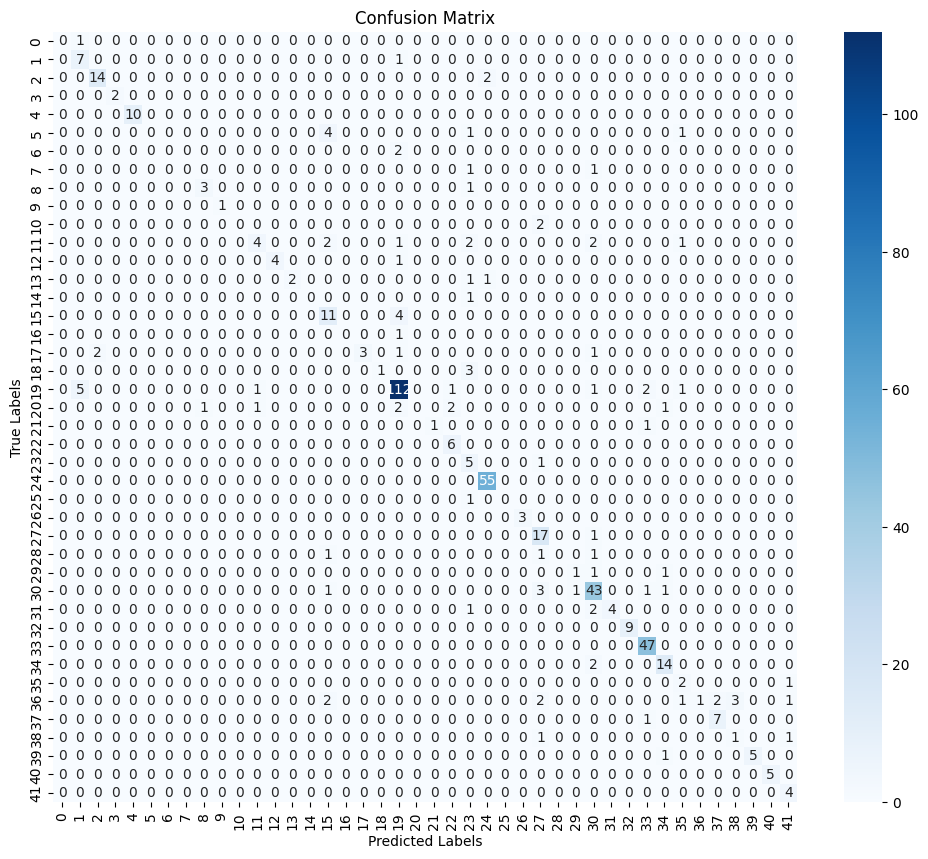

In [52]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['fine_label'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('confusion_matrix.png')
plt.show()

In [53]:
predictions = trainer.predict(train_dataloader)

  0%|          | 0/8 [00:00<?, ?it/s]

In [54]:
predicted_labels = predictions.predictions.argmax(axis=1)

In [55]:
predicted_labels

array([18, 38, 15, 26, 13, 29, 29, 35, 13, 29, 32, 29, 40, 32, 29, 35, 36,
       24, 24, 32, 29,  1, 29,  4, 32, 29, 28, 35, 28,  1, 40, 35, 15, 35,
       38, 13, 35, 24, 29, 24, 44, 28, 35,  1, 24, 29, 35, 35, 29, 27, 29,
       35, 24, 28, 24, 29, 29, 24, 35, 18, 32,  9, 38, 49, 39, 29, 29, 28,
        9, 26,  9, 35, 24, 38, 13,  2,  9, 28, 29,  1,  1, 29, 49, 29,  1,
       28, 39, 13, 29, 24, 29, 38, 49, 29, 27, 38,  1, 32,  1, 29, 38,  1,
       24, 28,  9, 35, 40, 28, 27, 35, 39, 27, 26, 29, 28, 29, 32, 27, 24,
       32, 35, 38, 29, 24, 35, 38, 32, 10, 29, 39, 27, 28, 29, 24, 40, 13,
       32, 32, 36,  1, 32, 15, 24, 29, 18, 24, 29, 32, 28, 35, 27, 24, 27,
       27, 34,  2, 49, 35, 32, 38, 24, 24, 24, 28, 32, 29, 24, 29, 29, 24,
       29, 15,  1, 28, 35, 38, 27, 38, 38, 29, 29, 26, 21, 29, 38,  9, 39,
       35, 39,  9, 39, 29,  1, 15, 35, 24, 39, 35, 39, 31, 29, 38, 35, 39,
       29, 28, 29, 39, 24, 39, 35, 38, 39, 35, 29, 38, 38, 29, 38, 13, 31,
       36, 28, 29,  1,  3

In [56]:
x_labels

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

In [58]:
import csv


# Combine the lists into a list of tuples
data = list(zip(x_labels, accuracy_list, precision_list, recall_list, loss_list))

# Specify the file name
csv_file_name = "TREC_Fine_label_ACC.csv"

# Write the data to a CSV file
with open(csv_file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    csv_writer.writerow(['Labels', 'accuracy', 'precision', 'recall', 'loss'])
    
    # Write the data
    csv_writer.writerows(data)

print(f"CSV file '{csv_file_name}' has been created.")


CSV file 'TREC_Fine_label_ACC.csv' has been created.
